Loaded 28 passes.


/tmp/ipykernel_640902/850631540.py:153: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pass_colors = cm.get_cmap('tab20').colors


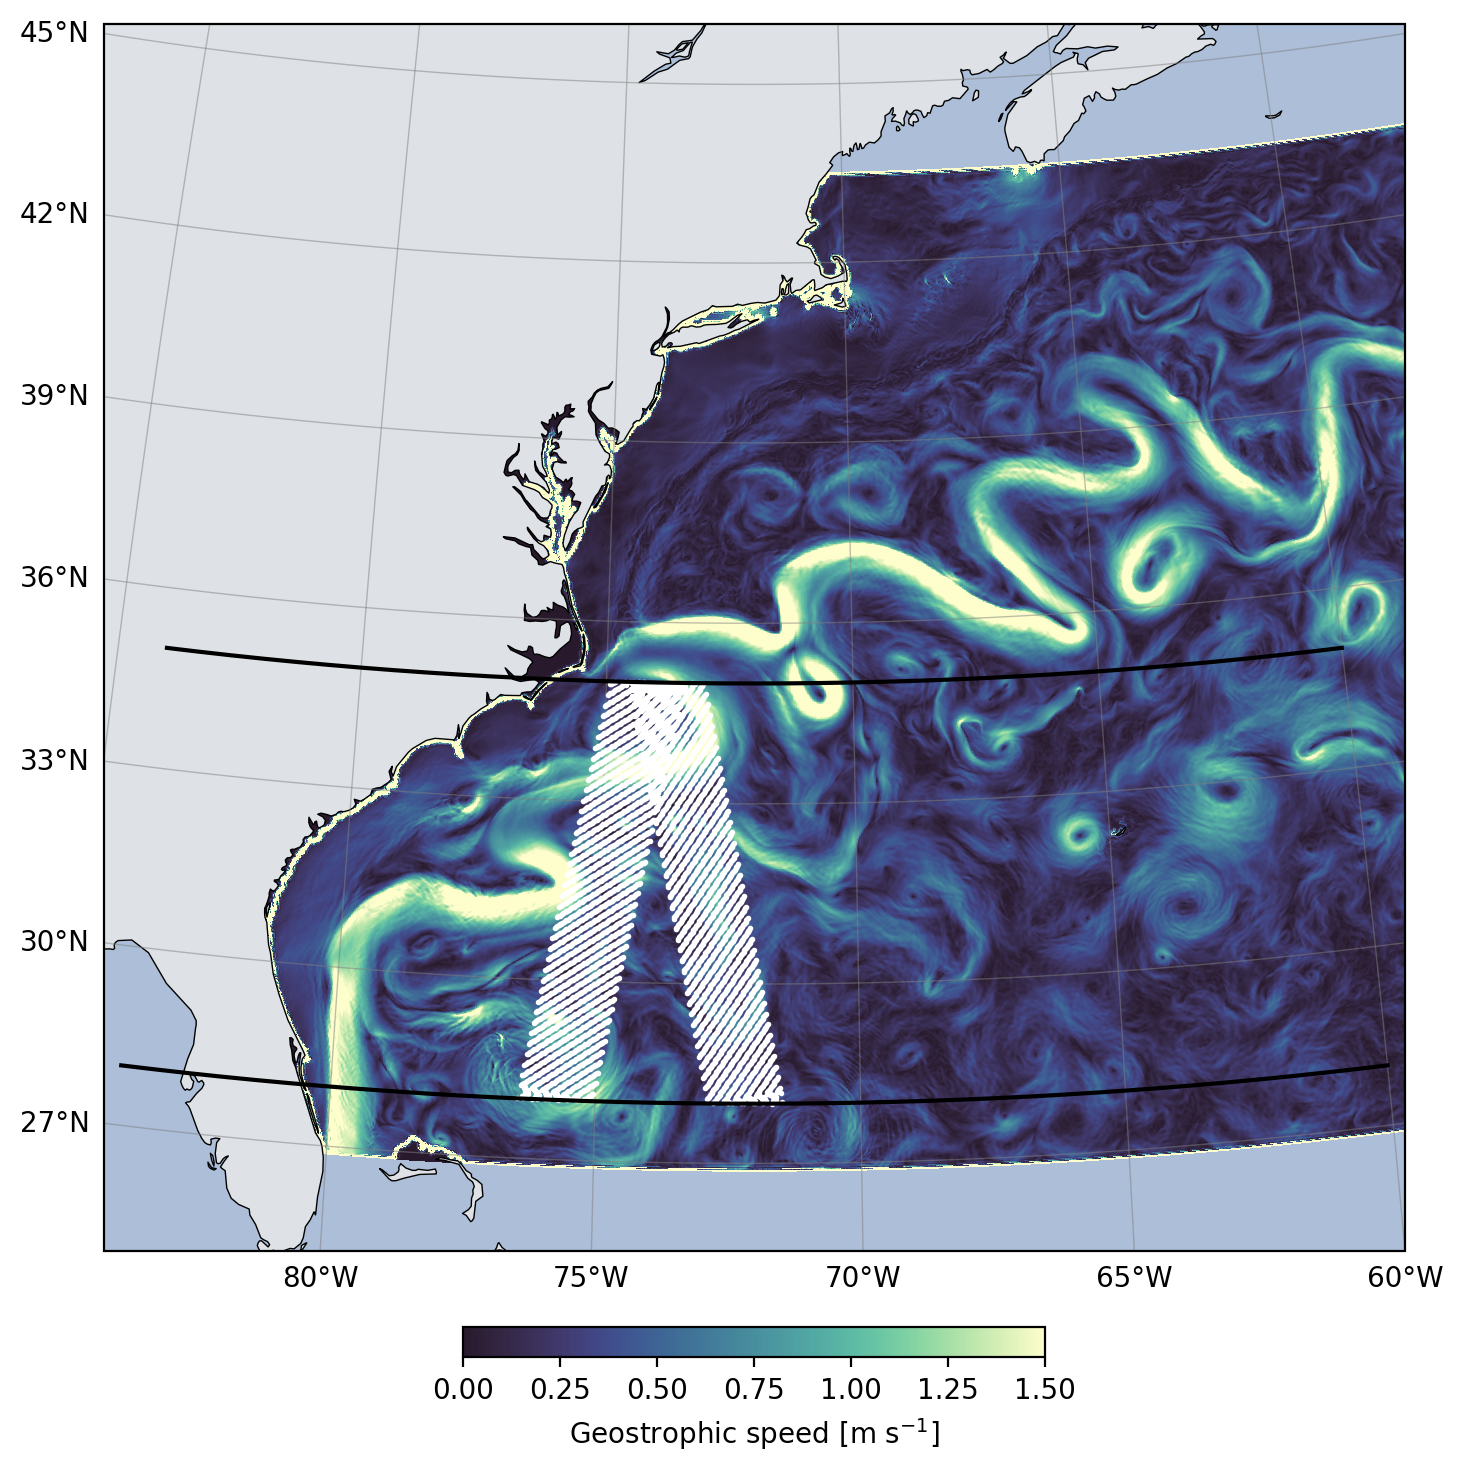

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as colors
import cmocean
from scipy.io import loadmat
from scipy.interpolate import griddata
import pickle
import matplotlib.cm as cm

# --- constants ---
g = 9.81                      # m/s^2
Omega = 7.2921150e-5          # Earth's rotation rate, rad/s
R_earth = 6371000.0           # m

# --- finite-difference geostrophic computation ---
def geostrophic_from_ssh(ssh, lon_grid, lat_grid):
    """
    ssh: 2D array with shape (nlat, nlon) corresponding to lat_grid (1D) and lon_grid (1D).
    lon_grid, lat_grid: 1D arrays in degrees.
    Returns: u (eastward), v (northward), speed (m/s) arrays same shape as ssh.
    """
    # ensure arrays
    ssh = np.array(ssh)
    lon_grid = np.array(lon_grid)
    lat_grid = np.array(lat_grid)
    nlat, nlon = ssh.shape
    assert lat_grid.size == nlat and lon_grid.size == nlon, "Grid shapes mismatch"

    # convert to radians spacing
    dlon_rad = np.deg2rad(lon_grid[1] - lon_grid[0])
    dlat_rad = np.deg2rad(lat_grid[1] - lat_grid[0])

    # dy is constant (meters) for equal-degree lat grid
    dy = R_earth * dlat_rad  # scalar

    # dx depends on latitude
    lat_rad = np.deg2rad(lat_grid)             # shape (nlat,)
    dx_per_lat = R_earth * np.cos(lat_rad) * dlon_rad  # shape (nlat,)

    # allocate derivatives (m/m -> dimensionless gradient of SSH per meter)
    dssh_dy = np.zeros_like(ssh)
    dssh_dx = np.zeros_like(ssh)

    # derivative in latitude (axis 0) -> /dy
    # central differences
    dssh_dy[1:-1, :] = (ssh[2:, :] - ssh[:-2, :]) / (2.0 * dy)
    # forward/backward
    dssh_dy[0, :] = (ssh[1, :] - ssh[0, :]) / dy
    dssh_dy[-1, :] = (ssh[-1, :] - ssh[-2, :]) / dy

    # derivative in longitude (axis 1) -> depends on dx_per_lat[i]
    for i in range(nlat):
        dx = dx_per_lat[i]
        # central
        dssh_dx[i, 1:-1] = (ssh[i, 2:] - ssh[i, :-2]) / (2.0 * dx)
        # forward/backward
        dssh_dx[i, 0] = (ssh[i, 1] - ssh[i, 0]) / dx
        dssh_dx[i, -1] = (ssh[i, -1] - ssh[i, -2]) / dx

    # Coriolis parameter f (2 * Omega * sin(lat))
    # Build mesh for lat matching ssh shape
    lat_mesh_rad = np.deg2rad(lat_grid)[:, None]  # shape (nlat, 1)
    f = 2.0 * Omega * np.sin(lat_mesh_rad)        # broadcasts to (nlat, 1)

    # avoid division by extremely small f (e.g., near equator)
    fmask = np.abs(f) < 1e-8
    f_safe = f.copy()
    f_safe[fmask] = np.nan  # will produce NaNs in u/v where f ~ 0

    # Geostrophic velocities (u eastward, v northward)
    u = - (g / f_safe) * dssh_dy
    v =   (g / f_safe) * dssh_dx

    speed = np.sqrt(np.nan_to_num(u)**2 + np.nan_to_num(v)**2)

    return u, v, speed

# -------------------------
# === Load pass coordinates (unchanged) ===
with open("SWOT_pass_coordinates.pkl", "rb") as f:
    pass_coords = pickle.load(f)

print(f"Loaded {len(pass_coords)} passes.")

pass_009 = pass_coords[8]
pass_022 = pass_coords[21]
pass_020 = pass_coords[19]
pass_007 = pass_coords[6]
pass_005 = pass_coords[4]
pass_018 = pass_coords[17]

# === Load MITgcm data ===
filename = '/expanse/lustre/projects/cit197/jskinner1/NA_daily_snapshots/snapshot_2026_05_10.mat'
data = loadmat(filename)
ssh = data['ssh']           # shape should be (nlat, nlon) [verify]
lons = data['XC']           # same shape as ssh
lats = data['YC']

# Ensure lons/lats are 1D coordinate arrays for interpolation grid
# If XC/YC are 2D, derive 1D grids by taking unique rows/cols:
if lons.ndim == 2:
    lon_vals = np.unique(lons)
else:
    lon_vals = lons
if lats.ndim == 2:
    lat_vals = np.unique(lats)
else:
    lat_vals = lats

Nx = lon_vals.size
Ny = lat_vals.size

# === Domain bounds and interpolation grid ===
lon_min, lon_max = np.min(lon_vals), np.max(lon_vals)
lat_min, lat_max = np.min(lat_vals), np.max(lat_vals)

# create higher-resolution regular grid
lon_grid = np.linspace(lon_min, lon_max, Nx * 2)
lat_grid = np.linspace(lat_min, lat_max, Ny * 2)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)  # shapes (nlat, nlon)

# Flatten original XC/YC and SSH for griddata if they are 2D:
orig_lon = lons.flatten()
orig_lat = lats.flatten()
orig_ssh = ssh.flatten()

# === Interpolate SSH onto regular lat-lon grid ===
proc_ssh_interpolated = griddata(
    (orig_lon, orig_lat),
    orig_ssh,
    (lon_mesh, lat_mesh),
    method='cubic'
)

# If any NaNs remain after interpolation (near edges), fall back to nearest
if np.any(np.isnan(proc_ssh_interpolated)):
    proc_ssh_interpolated = griddata(
        (orig_lon, orig_lat),
        orig_ssh,
        (lon_mesh, lat_mesh),
        method='nearest'
    )

# === compute geostrophic velocities ===
# Note: geostrophic_from_ssh expects shape (nlat, nlon) where lat_grid size matches nlat
u_geo, v_geo, speed_geo = geostrophic_from_ssh(proc_ssh_interpolated, lon_grid, lat_grid)

# === Define passes for plotting ===
passes = [pass_009, pass_022, pass_020, pass_007, pass_005, pass_018]
pass_labels = ['009', '022', '020', '007', '005', '018']
pass_colors = cm.get_cmap('tab20').colors

# === Plot ===
pad = 2.0  # degrees
lon_min = -80 - pad
lon_max = -60 - pad
extent = [lon_min - pad, lon_max + pad, lat_min - pad, lat_max + pad]

central_lon = 0.5 * (lon_min + lon_max)
central_lat = 0.5 * (lat_min + lat_max)


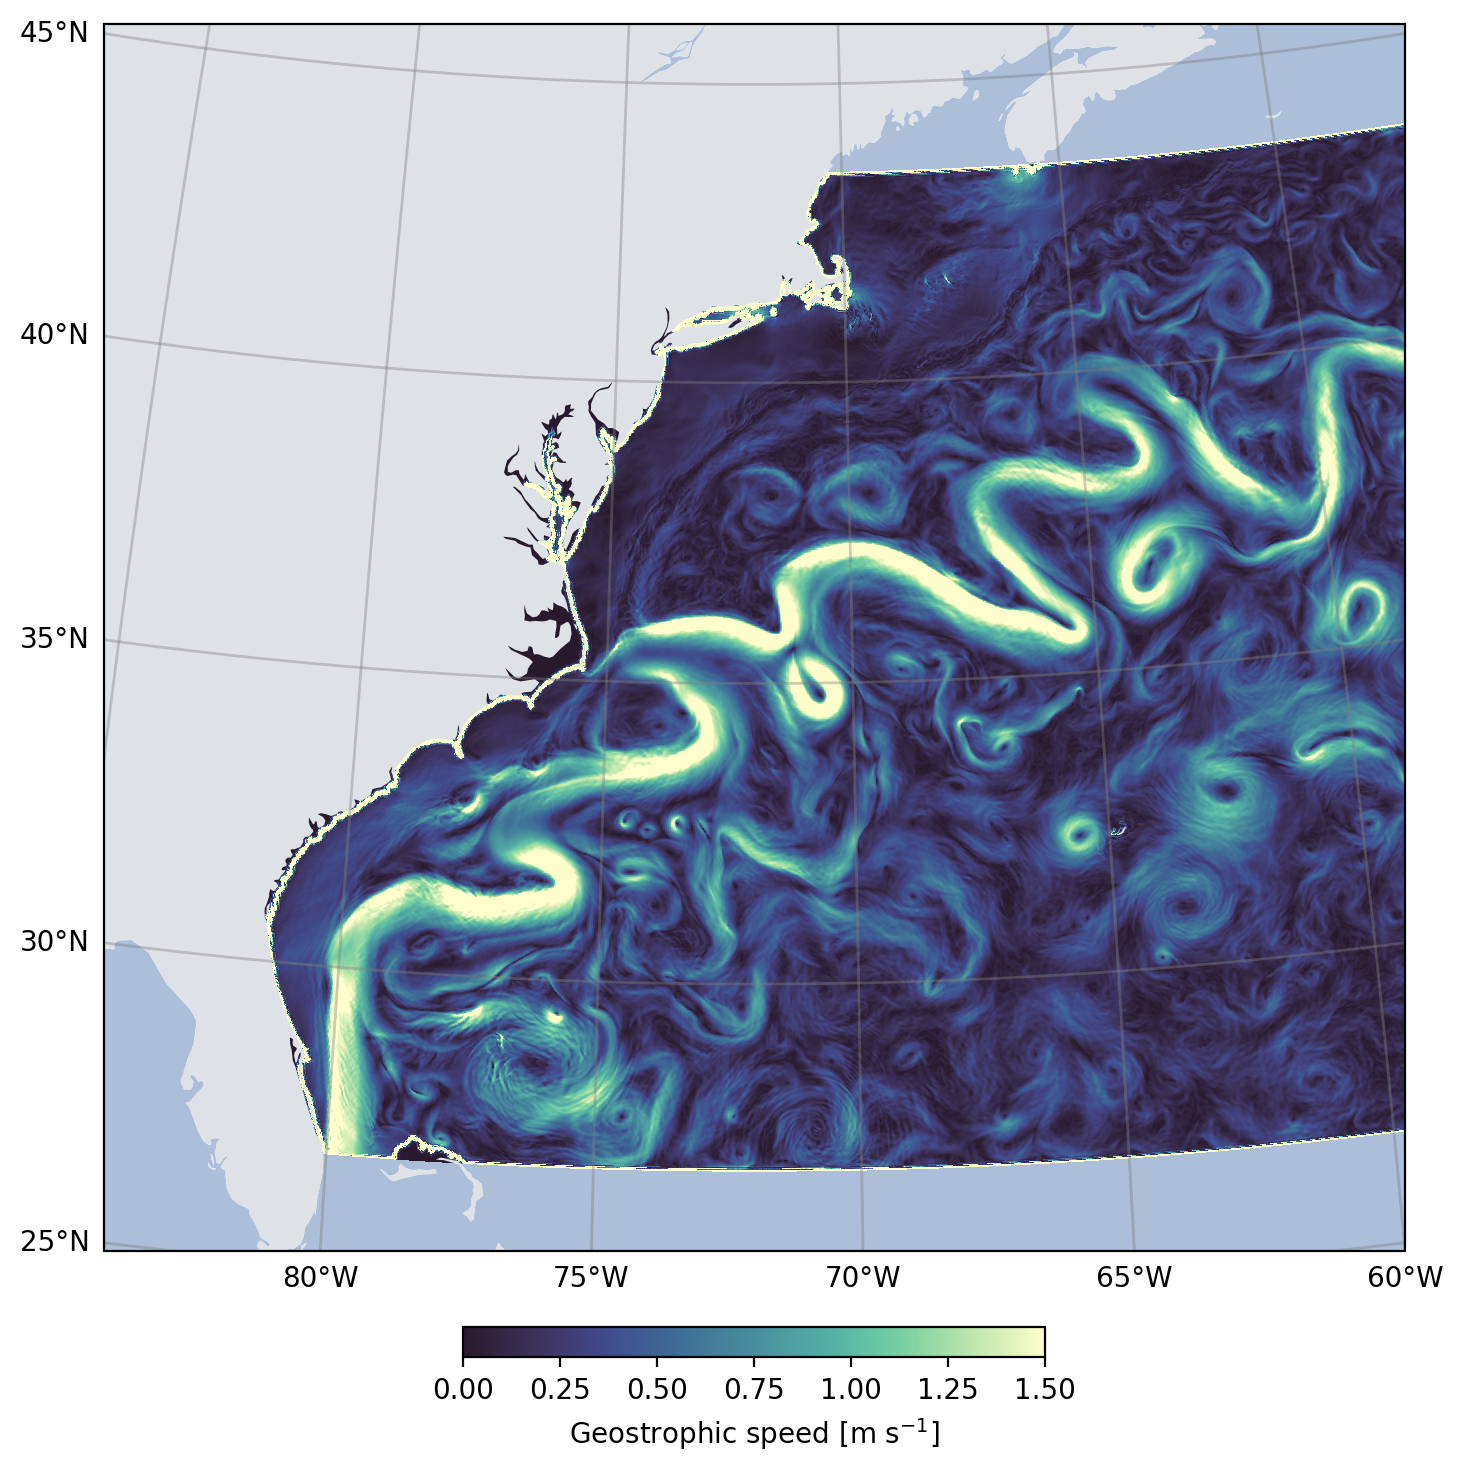

In [13]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.Orthographic(central_longitude=central_lon,
                                                central_latitude=central_lat)},
    dpi=200
)

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='#ACBED8')
ax.set_rasterization_zorder(2)

# === Plot speed as background ===
speed_plot = ax.pcolormesh(
    lon_mesh, lat_mesh, speed_geo,
    cmap=cmocean.cm.deep_r,
    transform=ccrs.PlateCarree(),
    zorder=1,
    vmin=0, vmax=1.5,
    rasterized=True    
)

ax.add_feature(cfeature.LAND, zorder=2, facecolor='#dee2e6')

#=== Add sparse pass scatters ===
LAT_MIN = 28.0
LAT_MAX = 35.0
for p, label, color in zip(passes, pass_labels, pass_colors):
    # original full arrays
    latp = np.asarray(p[1])  # latitudes (deg)
    lonp = np.asarray(p[2])  # longitudes (deg)

    print

    # crop by latitude, then sparsify (every 10th point)
    keep = (latp >= LAT_MIN) & (latp <= LAT_MAX)
    latp_c = latp[keep][::10]
    lonp_c = lonp[keep][::10]

    if latp_c.size == 0:
        continue  # nothing in range for this pass

    # ax.scatter(
    #     lonp[::5], latp[::5], s=1, color='white',
    #     transform=ccrs.PlateCarree(),
    #     label=f'Pass {label}', zorder=4, alpha=0.3, 
    #     rasterized=True
    # )

    # ax.scatter(
    #     lonp_c, latp_c, s=1, color='white',
    #     transform=ccrs.PlateCarree(),
    #     label=f'Pass {label}', zorder=4, alpha=1.0
    # )

# for y in [28, 35]:
#     ax.plot(
#         np.linspace(extent[0], extent[1], 720),
#         np.full(720, y),
#         color='k',
#         linewidth=1.5,
#         transform=ccrs.PlateCarree(),
#         zorder=5,
#         label=f'{y}°N'
#     )

# === Gridlines and labels ===
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1.0, color='gray', alpha=0.4, linestyle='-', zorder=4
)
gl.top_labels = gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 5))

# === Colorbar and quiver key ===
cbar = plt.colorbar(speed_plot, ax=ax, orientation='horizontal', shrink=0.3, pad=0.05)
cbar.set_label(r'Geostrophic speed [m s$^{-1}$]')

plt.savefig('NA_geostrophic_velocity.pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()